## Step 1. 데이터셋 내려받기 (Download Dataset)


In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import os

# tf_flowers 데이터셋을 train, validation, test로 분할
# Splitting tf_flowers into train, validation, test
(train_data, val_data, test_data), ds_info = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True
)

print(ds_info)
print("Train data size:", len(list(train_data)))
print("Validation data size:", len(list(val_data)))
print("Test data size:", len(list(test_data)))


Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.
tfds.core.DatasetInfo(
    name='tf_flowers',
    full_name='tf_flowers/3.0.1',
    description="""
    A large set of images of flowers
    """,
    homepage='https://www.tensorflow.org/tutorials/load_data/images',
    data_dir='/root/tensorflow_datasets/tf_flowers/incomplete.448RZQ_3.0.1/',
    file_format=tfrecord,
    download_size=218.21 MiB,
    dataset_size=221.83 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=5),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=3670, num_shards=2>,
    },
    citation="""@ONLINE {tfflowers,
    author = "The TensorFlow Team",
    title = "Flowers",
    month = "jan",
    year = "2019",
    url = "http://download.tensorflow.org/exa

## Step 2. 데이터셋 준비 (Data Preparation)


In [2]:
IMG_SIZE = 160

def format_example(image, label):
    # 이미지를 float32로 변환하고 [-1, 1] 구간으로 재조정
    # Convert image to float32 and scale pixel values to [-1, 1]
    image = tf.cast(image, tf.float32)
    image = (image / 127.5) - 1
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    return image, label

train = train_data.map(format_example)
val = val_data.map(format_example)
test = test_data.map(format_example)

BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
val_batches = val.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

# 샘플 확인
# Checking a sample batch
for image_batch, label_batch in train_batches.take(1):
    print("Image batch shape:", image_batch.shape)
    print("Label batch shape:", label_batch.shape)


Image batch shape: (32, 160, 160, 3)
Label batch shape: (32,)


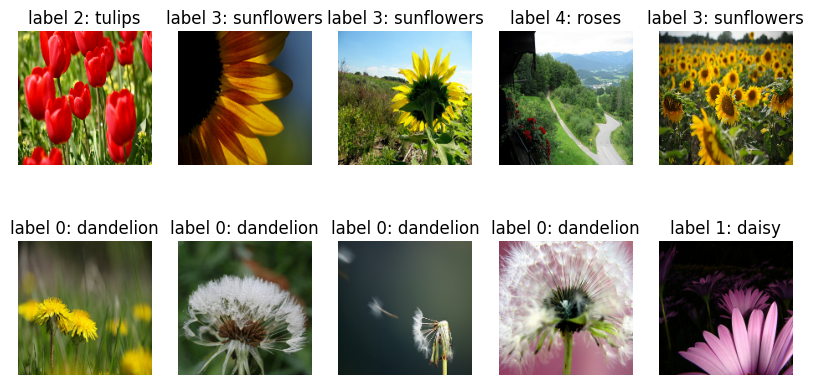

In [16]:
plt.figure(figsize=(10, 5))


get_label_name = ds_info.features['label'].int2str

for idx, (image, label) in enumerate(train.take(10)):
    plt.subplot(2, 5, idx+1)
    image = (image + 1) / 2
    plt.imshow(image)
    plt.title(f'label {label}: {get_label_name(label)}')
    plt.axis('off')

## Step 3. 모델 설계 (Model Design)


In [4]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

base_model = tf.keras.applications.VGG16(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False,
    weights='imagenet'
)

# Pretrained 모델의 학습을 동결 (Freeze the pretrained model)
base_model.trainable = False

# GlobalAveragePooling2D 레이어 준비
# Prepare the global average pooling layer
global_avg_layer = GlobalAveragePooling2D()

# 최종 분류 레이어 (tf_flowers는 5개 클래스)
# Final classification layer for 5 classes
prediction_layer = Dense(5, activation='softmax')

# 전체 모델 구성
# Build the full model
model = Sequential([
    base_model,
    global_avg_layer,
    Dense(512, activation='relu'),
    prediction_layer
])

model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 5, 5, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 5)                   │           2,565 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,979,909 (57.14 MB)

 Trainable params: 265,221 (1.01 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [7]:
learning_rate = 0.0001
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

In [8]:
validation_steps = 20
loss0, accuracy0 = model.evaluate(val_batches, steps=validation_steps)

print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

20/20 ━━━━━━━━━━━━━━━━━━━━ 13s 241ms/step - accuracy: 0.1398 - loss: 1.8957
initial loss: 1.87
initial accuracy: 0.16


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


## Step 4. 모델 학습 (Model Training)

In [9]:

EPOCHS = 10

history = model.fit(
    train_batches,
    epochs=EPOCHS,
    validation_data=val_batches
)


Epoch 1/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 19s 176ms/step - accuracy: 0.3426 - loss: 1.5340 - val_accuracy: 0.6485 - val_loss: 1.1803
Epoch 2/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 14s 112ms/step - accuracy: 0.6810 - loss: 1.1228 - val_accuracy: 0.7003 - val_loss: 0.9195
Epoch 3/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 11s 111ms/step - accuracy: 0.7331 - loss: 0.9060 - val_accuracy: 0.7330 - val_loss: 0.7990
Epoch 4/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 11s 113ms/step - accuracy: 0.7736 - loss: 0.7701 - val_accuracy: 0.7411 - val_loss: 0.7169
Epoch 5/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 20s 114ms/step - accuracy: 0.7975 - loss: 0.6777 - val_accuracy: 0.7657 - val_loss: 0.6662
Epoch 6/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 11s 113ms/step - accuracy: 0.7929 - loss: 0.6586 - val_accuracy: 0.7738 - val_loss: 0.6319
Epoch 7/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 11s 115ms/step - accuracy: 0.8208 - loss: 0.5944 - val_accuracy: 0.7820 - val_loss: 0.6171
Epoch 8/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 11s 114ms/step - accuracy: 0.8211 - loss: 0.5758 - val_accu

## Step 5. 모델 성능 평가 & 시각화 (Model Evaluation & Visualization)


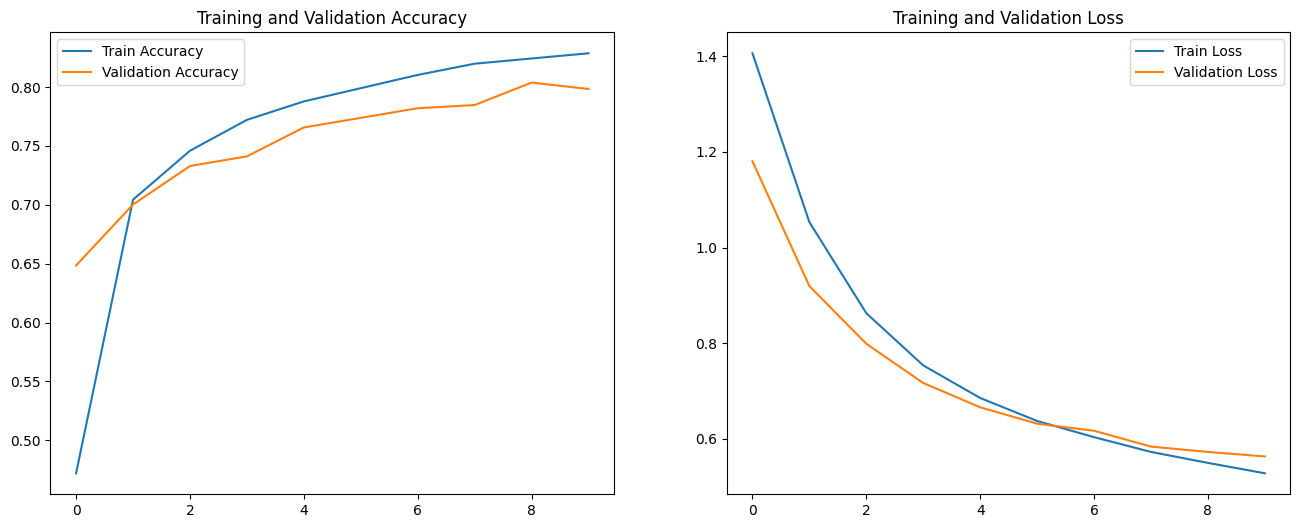

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step - accuracy: 0.8135 - loss: 0.5699
Test Loss: 0.5497, Test Accuracy: 0.8256


In [10]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

test_loss, test_acc = model.evaluate(test_batches)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")


In [11]:
for image_batch, label_batch in test_batches.take(1):
    images = image_batch
    labels = label_batch
    predictions = model.predict(image_batch)
    break

predictions

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


array([[3.33738178e-02, 7.17829391e-02, 6.53970897e-01, 8.25875923e-02,
        1.58284754e-01],
       [9.97632623e-01, 1.78458274e-03, 2.61540299e-05, 2.47832242e-04,
        3.08724731e-04],
       [7.84445703e-01, 8.97116065e-02, 2.12103855e-02, 8.15989450e-02,
        2.30333600e-02],
       [6.38166163e-03, 2.59702578e-02, 4.33281630e-01, 1.80553533e-02,
        5.16311049e-01],
       [7.04113603e-01, 2.29272604e-01, 1.77449025e-02, 2.13059392e-02,
        2.75629815e-02],
       [9.10168231e-01, 5.10900617e-02, 7.52487686e-03, 2.73864921e-02,
        3.83039634e-03],
       [1.60428267e-02, 2.15061251e-02, 6.77536249e-01, 1.95329145e-01,
        8.95857066e-02],
       [4.47873026e-01, 3.82957101e-01, 1.97366276e-03, 1.59174621e-01,
        8.02159309e-03],
       [1.48270885e-02, 2.28610239e-03, 2.65642051e-02, 8.59025896e-01,
        9.72966477e-02],
       [9.98509228e-01, 1.27161329e-03, 3.91569392e-06, 1.99755639e-04,
        1.55256002e-05],
       [9.63330626e-01, 2.7351

In [12]:
predictions = np.argmax(predictions, axis=1)
predictions

array([2, 0, 0, 4, 0, 0, 2, 0, 3, 0, 0, 3, 3, 4, 0, 3, 2, 0, 2, 4, 2, 0,
       1, 0, 1, 3, 2, 4, 4, 3, 0, 4])

In [13]:
plt.figure(figsize=(20, 12))

for idx, (image, label, prediction) in enumerate(zip(images, labels, predictions)):
    plt.subplot(4, 8, idx+1)
    image = (image + 1) / 2
    plt.imshow(image)
    correct = label == prediction
    title = f'real: {label} / pred :{prediction}\n {correct}!'
    if not correct:
        plt.title(title, fontdict={'color': 'red'})
    else:
        plt.title(title, fontdict={'color': 'blue'})
    plt.axis('off')

Output hidden; open in https://colab.research.google.com to view.

In [14]:
count = 0   # 정답을 맞춘 개수
for image, label, prediction in zip(images, labels, predictions):
    if label == prediction:
        count += 1

print(count / 32 * 100)

81.25


## Step 6. 모델 활용 (Model Usage)


In [18]:
# prompt: google drive mount

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predicted probabilities: [4.9579814e-03 9.7539574e-01 1.0890050e-03 1.8164804e-02 3.9247534e-04]
Predicted class index: 1


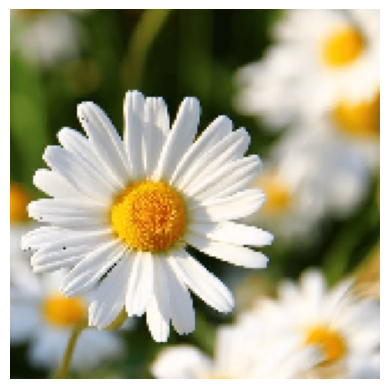

In [21]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

def show_and_predict_image(model, filepath, img_size=160):
    # 이미지 로드
    # Load the image
    image = load_img(filepath, target_size=(img_size, img_size))
    plt.imshow(image)
    plt.axis('off')

    # 모델 입력 형식으로 변환
    # Convert to model input shape
    image_array = img_to_array(image)
    image_array = (image_array / 127.5) - 1.0
    image_array = tf.expand_dims(image_array, axis=0)

    # 예측
    # Predict
    predictions = model.predict(image_array)[0]
    predicted_index = np.argmax(predictions)
    predicted_label = get_label_name(predicted_index)
    prediction_percentage = predictions[predicted_index] * 100

    print("Predicted probabilities:", predictions)
    print(f"Predicted class: {predicted_label} ({prediction_percentage:.2f}%)")

# Specify the path to any image you'd like to test.
sample_image_path = '/content/drive/MyDrive/datasets/flowers/daisy.jpg'  # 이미지 경로 예시
show_and_predict_image(model, sample_image_path)
